In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((y_true) * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0, 1]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=(28, 28, 1))
#     model = Sequential()
    x = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)(input)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

#     model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
#     model.summary()
#       x = Flatten()(input)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 50
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets


Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

#Swagam addition
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
input_shape = x_train.shape[1:]


# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

print(input_shape)
# network definition


(28, 28, 1)


In [4]:
input2 = Input(shape=input_shape)
print(input2)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])


Tensor("input_1:0", shape=(?, 28, 28, 1), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
print(tr_pairs[:, 0].shape)
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

(108400, 28, 28, 1)
Instructions for updating:
Use tf.cast instead.
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 144us/step - loss: 0.2743 - accuracy: 0.4974 - val_loss: 0.4871 - val_accuracy: 0.5000
Epoch 2/20
108400/108400 [==============================] - 13s 118us/step - loss: 0.2687 - accuracy: 0.4992 - val_loss: 0.4876 - val_accuracy: 0.5000
Epoch 3/20
108400/108400 [==============================] - 13s 116us/step - loss: 0.2666 - accuracy: 0.5007 - val_loss: 0.4908 - val_accuracy: 0.5000
Epoch 4/20
108400/108400 [==============================] - 13s 116us/step - loss: 0.2653 - accuracy: 0.4988 - val_loss: 0.4948 - val_accuracy: 0.5000
Epoch 5/20
108400/108400 [==============================] - 13s 115us/step - loss: 0.2642 - accuracy: 0.4989 - val_loss: 0.4955 - val_accuracy: 0.5000
Epoch 6/20
108400/108400 [==============================] - 13s 115us/step - loss: 0.2630 - accuracy: 0.5020 - val_loss: 0.496

In [6]:
a = x_test[24]
# print(a)
print(a.shape)
b = np.expand_dims(a, axis = 0)
print(b.shape)

(28, 28, 1)
(1, 28, 28, 1)


TypeError: ignored

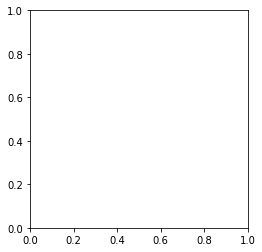

In [7]:
import matplotlib.pyplot as plt

plt.imshow(b)
print("Original Image\n")
plt.show()

In [0]:
# Make those columns into a array of 8-bits pixels
# This array will be of 1D with length 784
        # The pixel intensity values are integers from 0 to 255
pixels = x_test[26]
#pixels = np.array(pixels, dtype='uint8')
pixels *= 255.

        # Reshape the array into 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

        # Plot
plt.title('Label is {label}'.format(label=y_test[26]))
plt.imshow(pixels, cmap='gray')
plt.show()

In [0]:
im_1 = np.expand_dims(x_test[26], axis = 0)
im_2 = np.expand_dims(x_test[98], axis = 0)

In [0]:
output = model.predict([im_1, im_2])

In [0]:
print(output)

In [0]:
print(y_test[26], y_test[98])

In [0]:
!pip install foolbox

In [0]:
# !pip install keras scikit-learn imbalanced-learn

In [0]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [0]:
# import numpy as np
# import keras
# from sklearn.datasets import fetch_lfw_people
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# %matplotlib inline
# import matplotlib.pyplot as plt
# from imblearn.over_sampling import RandomOverSampler

In [0]:
# lfw_people = fetch_lfw_people(min_faces_per_person=35, color=False, resize=1.0,
#                               slice_=(slice(48, 202), slice(48, 202)))

# X_lfw = lfw_people.images
# Y_lfw = lfw_people.target
# target_names = lfw_people.target_names
# n_classes = target_names.shape[0]

# print('number of examples: {}'.format(Y_lfw.shape[0]))
# print('dimensionality of images: {}'.format(X_lfw.shape[1:]))
# print('number of unique classes (people): {}'.format(n_classes))

In [0]:
# _ = plt.hist(y, bins=n_classes)

In [0]:
# print(lfw_people.images[0])
# plt.imshow(lfw_people.images[0].astype(np.uint8))

In [0]:
# i = np.random.randint(len(lfw_people.images))
# plt.imshow(lfw_people.images[i].astype(np.uint8))
# plt.grid(False)
# print(target_names[Y_lfw[i]])

In [0]:
# print(lfw_people.images.shape)

In [0]:
# def create_pairs_lfw(x, digit_indices):
#     '''Positive and negative pair creation.
#     Alternates between positive and negative pairs.
#     '''
#     pairs = []
#     labels = []
#     n = min([len(digit_indices[d]) for d in range(n_classes)]) - 1
#     for d in range(n_classes):
#         for i in range(n):
#             z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
#             pairs += [[x[z1], x[z2]]]
#             inc = random.randrange(1, n_classes)
#             dn = (d + inc) % n_classes
#             z1, z2 = digit_indices[d][i], digit_indices[dn][i]
#             pairs += [[x[z1], x[z2]]]
#             labels += [0, 1]
#     return np.array(pairs), np.array(labels)

In [0]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.05,
#     zoom_range=0.1)

In [0]:
# from keras import Model

# batch_size = 256
# test_split = 0.2
# base_lr = 0.01
# epochs = 100

# # train/test split
# X_train_lfw, X_test_lfw, Y_train_lfw, Y_test_lfw = train_test_split(X_lfw, Y_lfw, test_size=test_split, 
#                                                     stratify=Y_lfw, random_state=42)

# # oversampling each class to contain at least 256 examples
# sampling_targets = np.maximum([256] * n_classes, np.bincount(Y_train_lfw))
# ratio_dict = dict(zip(range(n_classes), sampling_targets))
# ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

# X_train_shape = X_train_lfw.shape
# X_train_lfw = np.reshape(X_train_lfw, (X_train_shape[0], -1))
# X_train_lfw, Y_train_lfw = ros.fit_sample(X_train_lfw, Y_train_lfw)
# X_train_lfw = np.reshape(X_train_lfw, (len(X_train_lfw),) + X_train_shape[1:])

# # one-hot encoding of labels
# # Y_train_lfw = keras.utils.to_categorical(Y_train_lfw, n_classes)
# # Y_test_lfw = keras.utils.to_categorical(Y_test_lfw, n_classes)

In [0]:

# X_train_lfw = X_train_lfw.reshape(X_train_lfw.shape[0], X_train_lfw.shape[1], X_train_lfw.shape[2],1)
# X_test_lfw = X_test_lfw.reshape(X_test_lfw.shape[0], X_test_lfw.shape[1], X_test_lfw.shape[2],1)
# input_shape = X_train_lfw.shape[1:]

# print(Y_train_lfw.shape)
# # create training+test positive and negative pairs
# digit_indices = [np.where(Y_train_lfw == i)[0] for i in range(n_classes)]
# tr_pairs_lfw, tr_y_lfw = create_pairs_lfw(X_train_lfw, digit_indices)
# print(tr_pairs_lfw[:, 0].shape)
# digit_indices = [np.where(Y_test_lfw == i)[0] for i in range(n_classes)]
# te_pairs_lfw, te_y_lfw = create_pairs_lfw(X_test_lfw, digit_indices)

# print(input_shape)

In [0]:
# def create_base_network_lfw(input_shape):
#     '''Base network to be shared (eq. to feature extraction).
#     '''
#     input1 = Input(shape=(154, 154, 1))
# #     model = Sequential()
#     x = Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(154, 154))(input1)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.25)(x)
#     x = Dense(n_classes, activation='softmax')(x)

# #     model.compile(loss=keras.losses.categorical_crossentropy,
# #               optimizer=keras.optimizers.Adadelta(),
# #               metrics=['accuracy'])
# #     model.summary()
# #       x = Flatten()(input)
# #     x = Dense(128, activation='relu')(x)
# #     x = Dropout(0.1)(x)
# #     x = Dense(128, activation='relu')(x)
# #     x = Dropout(0.1)(x)
# #     x = Dense(128, activation='relu')(x)
#     return Model(input1, x)

In [0]:
# base_network_lfw = create_base_network_lfw((154, 154))

# input_a_lfw = Input(shape=(154, 154, 1))
# input_b_lfw = Input(shape=(154, 154, 1))

# # because we re-use the same instance `base_network`,
# # the weights of the network
# # will be shared across the two branches
# processed_a_lfw = base_network_lfw(input_a_lfw)
# processed_b_lfw = base_network_lfw(input_b_lfw)

# distance = Lambda(euclidean_distance,
#                   output_shape=eucl_dist_output_shape)([processed_a_lfw, processed_b_lfw])

# model = Model([input_a_lfw, input_b_lfw], distance)

# print(tr_pairs_lfw.shape)
# # train
# rms = RMSprop()
# model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# model.fit([tr_pairs_lfw[:, 0], tr_pairs_lfw[:, 1]], tr_y_lfw,
#           batch_size=128,
#           epochs=20,
#           validation_data=([te_pairs_lfw[:, 0], te_pairs_lfw[:, 1]], te_y_lfw))

# # compute final accuracy on training and test sets
# y_pred_train_lfw = model.predict([tr_pairs_lfw[:, 0], tr_pairs_lfw[:, 1]])
# tr_acc_lfw = compute_accuracy(tr_y_lfw, y_pred_train_lfw)
# y_pred_test_lfw = model.predict([te_pairs_lfw[:, 0], te_pairs_lfw[:, 1]])
# te_acc_lfw = compute_accuracy(te_y_lfw, y_pred_test_lfw)

# print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc_lfw))
# print('* Accuracy on test set: %0.2f%%' % (100 * te_acc_lfw))


In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [0]:
import matplotlib.pyplot as plt

pixels = x_test[20]
#pixels = np.array(pixels, dtype='uint8')
pixels *= 255.

        # Reshape the array into 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

        # Plot
plt.title('Label is {label}'.format(label=y_test[20]))
plt.imshow(pixels, cmap='gray')
plt.show()

In [0]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img = image.load_img("3_og.png", color_mode = "grayscale", target_size=((28, 28)))
og_image = image.img_to_array(img)

img = image.load_img("3_og_1.png", color_mode = "grayscale", target_size=((28, 28)))
original_image = image.img_to_array(img)

img = image.load_img("3_hack.png", color_mode = "grayscale", target_size=((28, 28)))
hack_image = image.img_to_array(img)

im_1 = np.expand_dims(x_test[20], axis = 0)
print(im_1.shape)
im_2 = np.expand_dims(original_image, axis = 0)
print(original_image.shape)

og = original_image.reshape((1,28,28))
fake = hack_image.reshape((1,28,28))
og1 = og_image.reshape((1,28,28))
# print(hack.shape)

In [0]:
output = model.predict([fake, fake])
f = compute_accuracy(y_test[20], output)

In [0]:
print(output)
print(f)

In [0]:
print(tr_y[0])